## How New Yorkers Bike

###### Goal: record number of bikes available every minute in NYC for an hour, in order to determine which station is most active
- activity defined as total number of bikes taken in or out within the hour (so, 2 taken out + 4 returned = 6 total)

### Getting Citi Bike data

In [1]:
#requests allows us to download files from a URL
import requests
r = requests.get('http://www.citibikenyc.com/stations/json')

### Cleaning Citi Bike data

In [2]:
#r.text will give basic view of what's contained in r
#print r.text

#data is formatted as JSON  - access elements of JSON in same way access elements of dict (i.e. with keys)
print r.json().keys()

#executionTime key returns time when file was created as a string
print r.json()['executionTime']

#stationBeanList key returns list of stations
print "Number of stations: {}".format(len(r.json()['stationBeanList']))


[u'executionTime', u'stationBeanList']
2015-08-16 11:52:23 AM
Number of stations: 507


In [3]:
#create list of all the fields associated with the stations 
key_list = [] #unique list of keys for each station listing
for station in r.json()['stationBeanList']:
    for k in station.keys():
        if k not in key_list:
            key_list.append(k)
key_list

[u'availableDocks',
 u'totalDocks',
 u'city',
 u'altitude',
 u'stAddress2',
 u'longitude',
 u'lastCommunicationTime',
 u'postalCode',
 u'statusValue',
 u'testStation',
 u'stAddress1',
 u'stationName',
 u'landMark',
 u'latitude',
 u'statusKey',
 u'availableBikes',
 u'id',
 u'location']

In [4]:
#convert data in df
from pandas.io.json import json_normalize

df = json_normalize(r.json()['stationBeanList'])
df.head()

  altitude  availableBikes  availableDocks city   id landMark  \
0                        0              39        72            
1                        6              22        79            
2                       15              11        82            
3                       62               0        83            
4                       12              25       116            

    lastCommunicationTime   latitude location  longitude postalCode  \
0  2015-08-16 11:49:44 AM  40.767272          -73.993929              
1  2015-08-16 11:48:59 AM  40.719116          -74.006667              
2  2015-08-16 11:50:46 AM  40.711174          -74.000165              
3  2015-08-16 11:48:47 AM  40.683826          -73.976323              
4  2015-08-16 11:51:07 AM  40.741776          -74.001497              

                      stAddress1 stAddress2                    stationName  \
0               W 52 St & 11 Ave                          W 52 St & 11 Ave   
1       Franklin St & W Br

In [5]:
#look at range for available bikes
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

df['availableBikes'].hist()

In [6]:
#look at range for available docks
df['availableDocks'].hist()

In [8]:
df['totalDocks'].hist()

In [9]:
print df.info()
print df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507 entries, 0 to 506
Data columns (total 18 columns):
altitude                 507 non-null object
availableBikes           507 non-null int64
availableDocks           507 non-null int64
city                     507 non-null object
id                       507 non-null int64
landMark                 507 non-null object
lastCommunicationTime    507 non-null object
latitude                 507 non-null float64
location                 507 non-null object
longitude                507 non-null float64
postalCode               507 non-null object
stAddress1               507 non-null object
stAddress2               507 non-null object
stationName              507 non-null object
statusKey                507 non-null int64
statusValue              507 non-null object
testStation              507 non-null bool
totalDocks               507 non-null int64
dtypes: bool(1), float64(2), int64(5), object(10)
memory usage: 71.8+ KB
None
       avail

In [10]:
total = len(df)
not_serv = len(df[df.statusValue == "Not In Service"])
servicing = total - not_serv
print "There are {} stations, {} in service and {} not in service".format(total, servicing, not_serv)


There are 507 stations, 346 in service and 161 not in service


In [15]:
#no test stations apparently
any(df[df.testStation].values)

False

In [12]:
print df.availableBikes.mean()
print df.availableBikes.median()

#if we remove stations that are not in service 
print df.availableBikes[df.statusValue == "In Service"].mean()
print df.availableBikes[df.statusValue == "In Service"].median()

9.20118343195
5.0
13.4826589595
12.0


In [13]:
#total docks should equal availableBikes + availableDocks, although it doesn't here
print df.totalDocks.sum()
print df.availableBikes.sum()
print df.availableDocks.sum()

print(df.availableDocks.sum() + df.availableBikes.sum())

12024
4665
6829
11494


### Store Citi Bike data

In [39]:
import sqlite3 as lite

con = lite.connect('citi_bike.db')
cur = con.cursor()

with con:
    cur.execute("DROP TABLE IF EXISTS citibike_reference")
    cur.execute('''CREATE TABLE citibike_reference
    (id INT PRIMARY KEY,
    totalDocks INT,
    city TEXT,
    altitude INT,
    stAddress2 TEXT,
    longitude NUMERIC,
    postalCode TEXT,
    testStation TEXT,
    stAddress1 TEXT,
    stationName TEXT,
    landMark TEXT,
    latitude NUMERIC,
    location TEXT )''')

#a prepared SQL statement we're going to execute over and over again
sql = """INSERT INTO citibike_reference 
      (id, totalDocks, city, altitude, stAddress2, longitude, postalCode, 
       testStation, stAddress1, stationName, landMark, latitude, location) 
      VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?)"""

#for loop to populate values in the database
with con:
    for station in r.json()['stationBeanList']:
        #id, totalDocks, city, altitude, stAddress2, longitude, postalCode, testStation, stAddress1, stationName, landMark, latitude, location)
        cur.execute(sql,
	(station['id'],
	station['totalDocks'],
	station['city'],
	station['altitude'],
	station['stAddress2'],
	station['longitude'],
	station['postalCode'],
	station['testStation'],
	station['stAddress1'],
	station['stationName'],
	station['landMark'],
	station['latitude'],
	station['location']))

#extract the column from the DataFrame and put them into a list
station_ids = df['id'].tolist() 

# #add the '_' to the station name and also add the data type for SQLite
station_ids = ['_' + str(x) + ' INT' for x in station_ids] 

# #create the table
# #in this case, we're concatentating the string and joining all the station ids (now with '_' and 'INT' added)
with con:
    cur.execute("DROP TABLE IF EXISTS available_bikes")
    cur.execute("CREATE TABLE available_bikes ( execution_time INT, " +  ", ".join(station_ids) + ");")

# # a package with datetime objects
import time

# # a package for parsing a string into a Python datetime object
from dateutil.parser import parse 

import collections


#take the string and parse it into a Python datetime object
exec_time = parse(r.json()['executionTime'])

#add entry for execution time to db
with con:
    cur.execute('INSERT INTO available_bikes (execution_time) VALUES (?)', (exec_time.strftime('%s'),))

id_bikes = collections.defaultdict(int) #defaultdict to store available bikes by station

#loop through the stations in the station list
for station in r.json()['stationBeanList']:
    id_bikes[station['id']] = station['availableBikes']

#iterate through the defaultdict to update the values in the database
with con:
    for k, v in id_bikes.iteritems():
        cur.execute("UPDATE available_bikes SET _" + str(k) + " = " + str(v) + " WHERE execution_time = " + exec_time.strftime('%s') + ";")

In [38]:
print exec_time
print exec_time.strftime('%s')

2015-08-16 11:52:23
1439743943


### Analyzing the Result

In [1]:
import pandas as pd
import sqlite3 as lite
import datetime

con = lite.connect('citi_bike.db')
cur = con.cursor()

df = pd.read_sql_query("SELECT * FROM available_bikes ORDER BY execution_time",con,index_col='execution_time')

In [2]:
df.head()

,_72,_79,_82,_83,_116,_119,_120,_127,_128,_137,...,_3208,_3209,_3210,_3211,_3212,_3213,_3214,_3215,_3216,_3217
execution_time,,,,,,,,,,,,,,,,,,,,,
1439759932,1,4,14,54,8,4,7,6,24,10,...,0,0,0,0,0,0,0,0,0,0
1439759998,1,4,14,54,9,4,7,6,24,10,...,0,0,0,0,0,0,0,0,0,0
1439760053,1,4,14,54,9,4,7,6,23,10,...,0,0,0,0,0,0,0,0,0,0
1439760118,1,4,14,54,9,4,7,6,23,10,...,0,0,0,0,0,0,0,0,0,0
1439760195,1,4,14,55,9,4,7,4,23,10,...,0,0,0,0,0,0,0,0,0,0


######Rationale
For any column (station) in the df, the total change is the sum of the absolute difference between [time_points + 1:end] - [time_points:end-1] - i.e. abs(df[station][1]-df[station][0]) + abs(df[station][2]-df[station][1])...+abs(df[station][n]-df[station][n-1]). We are then looking for the station(s) with the maximum total change. 

In [9]:
sums =  pd.DataFrame(abs(df[1:].values - df[:-1].values), columns=df.columns).sum()
most_active = sums[sums==sums.max()]

for index in most_active.index:
    id = int(index.strip("_"))
    hour_change = most_active[index]
    cur.execute("SELECT id, stationname, latitude, longitude FROM citibike_reference WHERE id = ?", (id,))
    data = cur.fetchone()
    print "The most active station is station id %s at %s latitude: %s longitude: %s " % data
    print("With " + str(hour_change) + " bicycles coming and going in the hour between " +
          datetime.datetime.fromtimestamp(int(df.index[0])).strftime('%Y-%m-%dT%H:%M:%S') + " and " +
          datetime.datetime.fromtimestamp(int(df.index[-1])).strftime('%Y-%m-%dT%H:%M:%S'))
    print

The most active station is station id 281 at Grand Army Plaza & Central Park S latitude: 40.7643971 longitude: -73.97371465 
With 57 bicycles coming and going in the hour between 2015-08-16T16:18:52 and 2015-08-16T17:18:12

The most active station is station id 2006 at Central Park S & 6 Ave latitude: 40.76590936 longitude: -73.97634151 
With 57 bicycles coming and going in the hour between 2015-08-16T16:18:52 and 2015-08-16T17:18:12



<Container object of 507 artists>

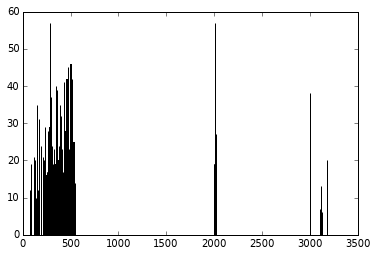

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
stations = sums.index.str.strip("_").astype(int)
plt.bar(stations, sums.values)